# 八叉树

八叉树是一种数据结构，其中每个节点有八个子节点，其通常用于3d点云的空间划分，每个非空节点包含一个或多个点云。  
open3d提供了一个几何数据类型octree，用于创建、搜索、遍历八叉树，同时可以自定义八叉树的最大深度max_depth

## 从点云中构建

In [1]:
import open3d as o3d
import numpy as np
import copy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


如果点云有颜色，则相应的叶节点采用最后插入点的颜色。size_expand参数增加根八叉树节点的大小，使其略大于原始点云边界以容纳所有点。

In [4]:
# 读取点云数据并下采样
mesh = o3d.io.read_triangle_mesh(r'G:\open3d\data\BunnyMesh.ply')

N = 2000
pcd = mesh.sample_points_uniformly(number_of_points=N)

# 缩放点云并赋色
pcd.scale(1 / np.max(pcd.get_max_bound() - pcd.get_min_bound()),
          center=pcd.get_center())
pcd.colors = o3d.utility.Vector3dVector(np.random.uniform(0, 1, size=(N, 3)))
o3d.visualization.draw_geometries([pcd])

# 构建八叉树
octree = o3d.geometry.Octree(max_depth=4) # 八叉树的最大深度为4
octree.convert_from_point_cloud(pcd, size_expand=0.01) # 使用convert_from_point_cloud将点云转换为八叉树，将边界向外扩展0.01以容纳所有点云
o3d.visualization.draw_geometries([octree])

[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


采样后的点云  
  
  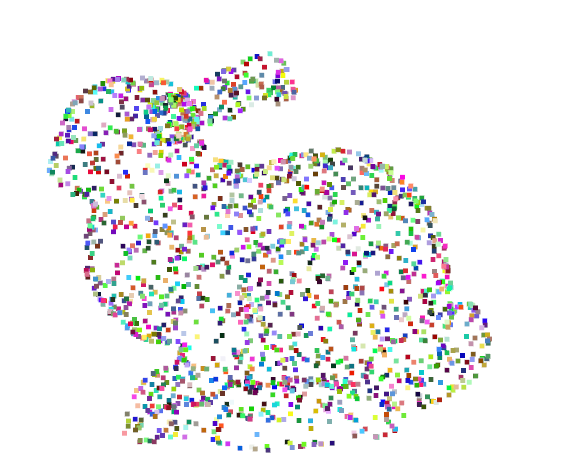

八叉树可视化
  
  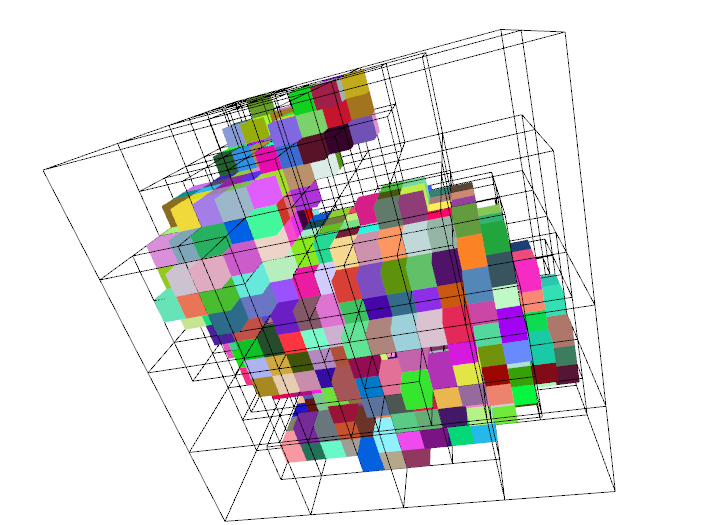

## 从体素中构建

输入的每个体素都被视为3D空间中的一个点，坐标对应于体素的原点，每个叶节点取其对应体素的颜色。

In [5]:
# 点云体素化
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd,voxel_size=0.05)
o3d.visualization.draw_geometries([voxel_grid])

# 从体素中构建八叉树
octree = o3d.geometry.Octree(max_depth=4)
octree.create_from_voxel_grid(voxel_grid)  # 使用create_from_voxel_grid
o3d.visualization.draw_geometries([octree])

[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


体素如图所示  
  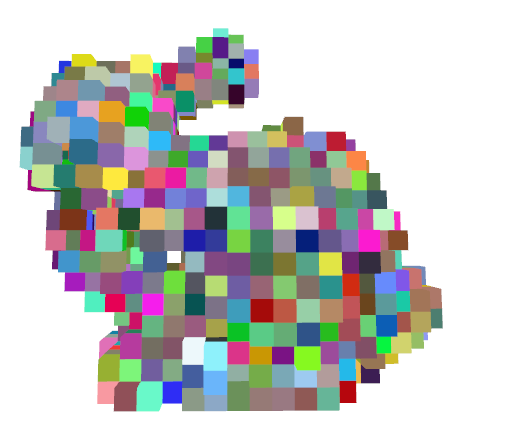

八叉树如图所示  
  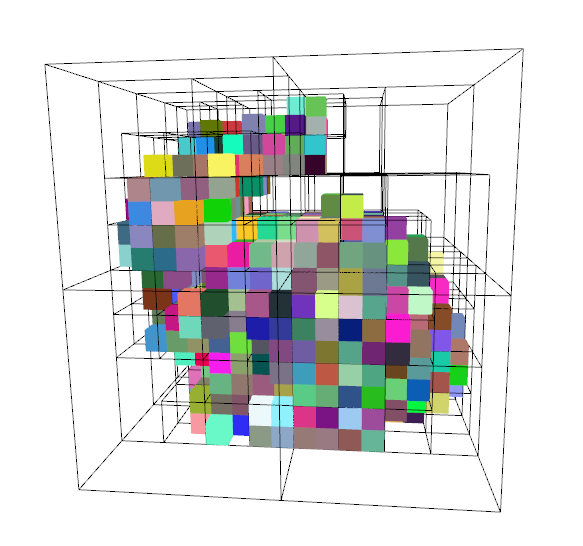

## 寻找选定点所处的叶节点

In [7]:
octree.locate_leaf_node(pcd.points[100]) # 寻找第100个点所处的叶节点，调用locate_leaf_node函数

(OctreeColorLeafNode with color [0.0892284, 0.407518, 0.300735],
 OctreeNodeInfo with origin [-0.489936, 0.269666, 0.0627271], size 0.065625, depth 4, child_index 2)

# 表面重建

要从非结构化点云数据中获取三角形网格，就需要执行表面重建。open3d提供了三种重建方法。

## Alpha shapes

该方法由Edelsbrunner等人提出，是凸包算法的推广。可以使用open3d中的create_from_point_cloud_alpha_shape函数调用，需要调整参数alpha

In [5]:
# 读取点云
pcd = o3d.io.read_point_cloud(r'G:\open3d\data\BunnyMesh.ply')

# 可视化点云效果
o3d.visualization.draw_geometries([pcd])
alpha = 0.03
print(f"alpha={alpha:.3f}")

# 调用TriangleMesh中的create_from_point_cloud_alpha_shape函数重建表面
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, alpha)
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

alpha=0.030
[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


点云可视化如下：  
  
  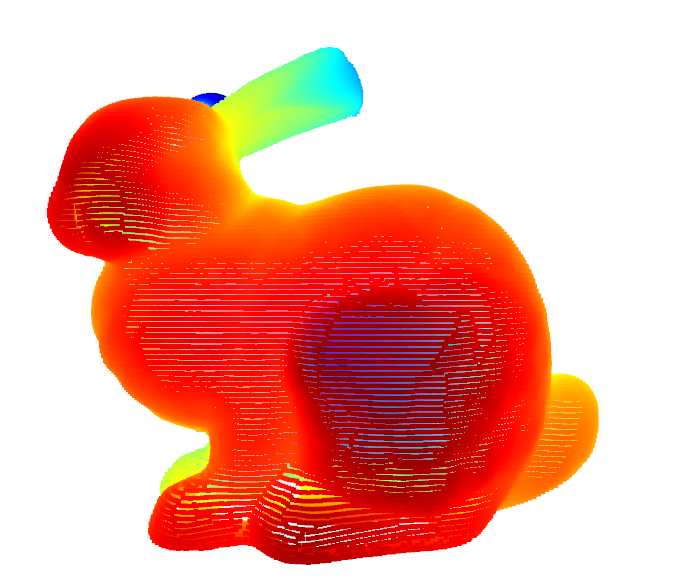

表面重建可视化如下：
  
  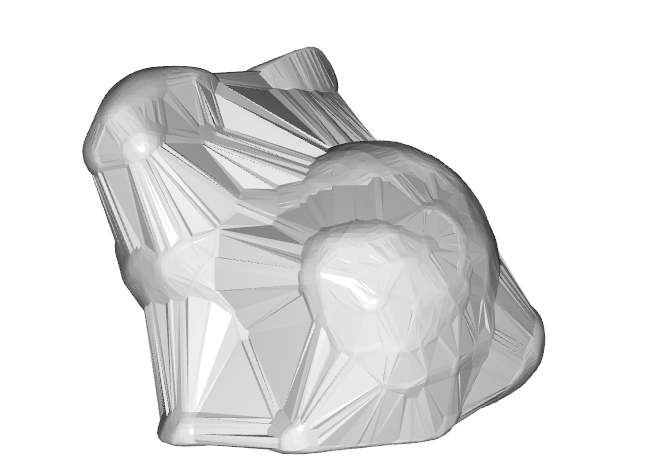

不同alpha的值会产生不同的重建效果

In [6]:
alpha = 0.01
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, alpha)
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)


alpha = 0.07
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, alpha)
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


alpha为0.01的效果  
  
  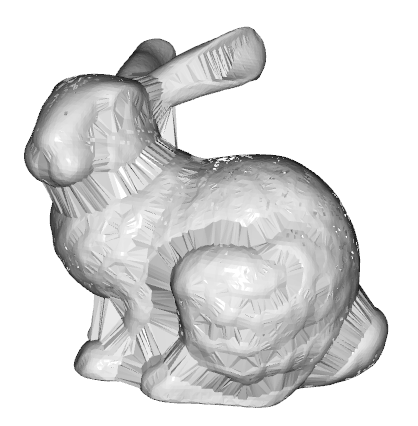

alpha为0.07的效果  

  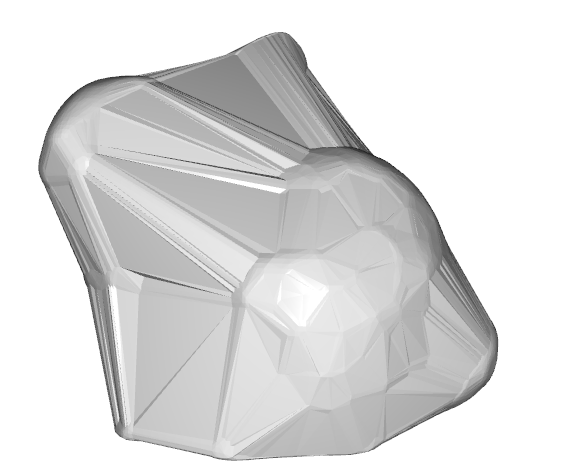

## Ball pivoting

该算法由Bernardini等人提出，其基本原理是通过让一个球在点云表面滚动，当球接触到三个点时，这三个点形成一个三角形，然后球继续滚动，形成更多的三角形，直到覆盖整个表面。  
open3d提供create_from_point_cloud_ball_pivoting函数，该函数需要一个半径列表作为参数，该参数对应于在点云上旋转的单个球的半径。

In [12]:
# 读取点云
pcd = o3d.io.read_point_cloud(r'G:\open3d\data\BunnyMesh.ply')
pcd.estimate_normals() # 该方法需要法向量，因此需要估算


radii = np.array([0.005, 0.01, 0.02, 0.04]) # 设置一个半径列表

rec_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd, o3d.utility.DoubleVector(radii)) # o3d.utility.DoubleVector可以将数组或列表转换为open3d格式

# 可视化
o3d.visualization.draw_geometries([rec_mesh])

可视化效果  
  
  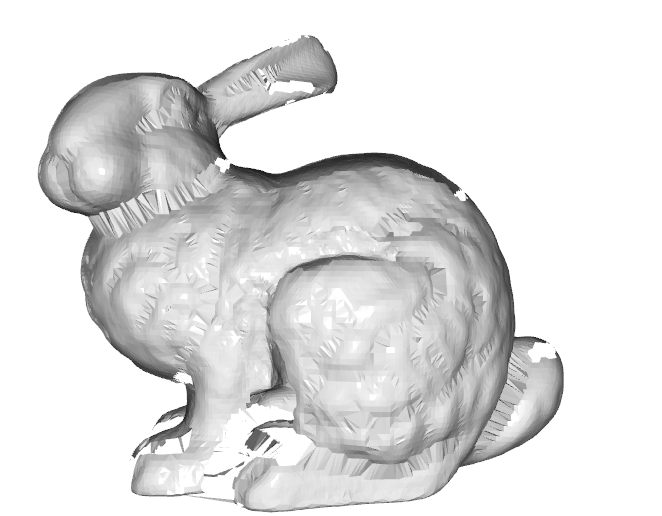

## Poisson表面重建

该方法由Kazhdan等人提出，并且效果优于上述方法。可以使用create_from_point_cloud_poisson函数调用，其中一个参数depth决定了分辨率，更大的depth意味着网格有更多细节 

In [19]:
# 读取点云
pcd = o3d.io.read_point_cloud(r'G:\open3d\data\BunnyMesh.ply')

# 该方法需要法向量，因此需要估算，并调整法线方向
pcd.estimate_normals()
pcd.orient_normals_consistent_tangent_plane(100) 


mesh, _ = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)
mesh.compute_vertex_normals()
mesh.paint_uniform_color(np.array([0.5,0.5,0.5]))

o3d.visualization.draw_geometries([mesh])



可视化效果  
  
  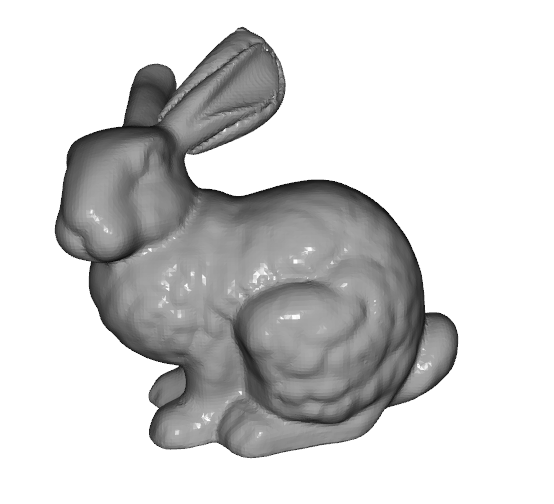

# 坐标转换

Open3D的几何类型有许多转换方法。常用的有使用平移、旋转、缩放和矩阵变换。

## 平移

平移只需要输入一个三维向量分别表示x,y,z的偏移量即可

In [3]:
# 新建一个坐标轴
mesh = o3d.geometry.TriangleMesh.create_coordinate_frame()

# 使用translate分别在x,y,z方向上进行平移
mesh_tx = copy.deepcopy(mesh).translate((1, 0, 0))
mesh_ty = copy.deepcopy(mesh).translate((0, 2, 0))
mesh_tz = copy.deepcopy(mesh).translate((0, 0, 3))


print(f'原始中心: {mesh.get_center()}')
print(f'往x轴平移后的中心: {mesh_tx.get_center()}')
print(f'往y轴平移后的中心: {mesh_ty.get_center()}')
print(f'往z轴平移后的中心: {mesh_tz.get_center()}')


o3d.visualization.draw_geometries([mesh, mesh_tx, mesh_ty, mesh_tz ])

原始中心: [0.05167549 0.05167549 0.05167549]
往x轴平移后的中心: [1.05167549 0.05167549 0.05167549]
往y轴平移后的中心: [0.05167549 2.05167549 0.05167549]
往z轴平移后的中心: [0.05167549 0.05167549 3.05167549]


可视化结果如图  


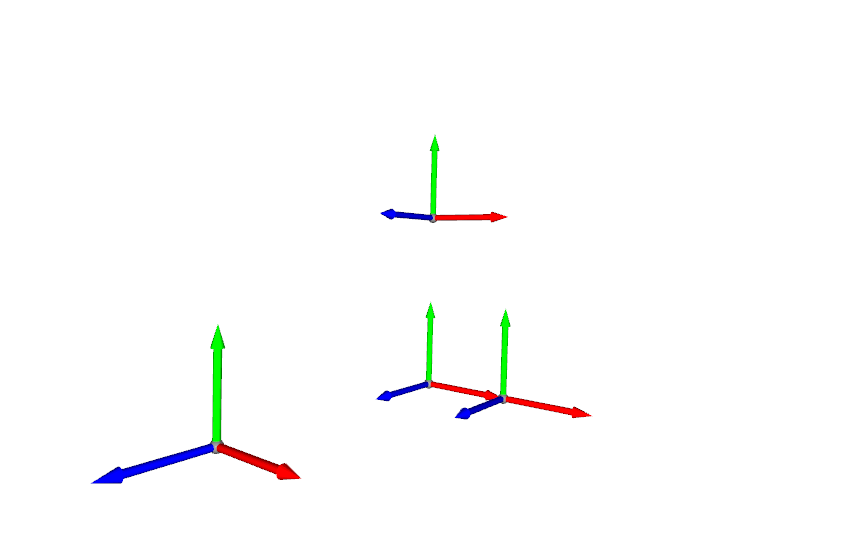

translate()有第二个参数relative,其默认为True，如果为False，mesh的中心会直接转换到第一个参数所表示的坐标  
也就是说，默认情况下，输入的三维向量应该表示平移的距离，如果relative为False，则输入的三维向量表示平移后mesh中心所处的位置

In [4]:
mesh = o3d.geometry.TriangleMesh.create_coordinate_frame()
mesh_mv = copy.deepcopy(mesh).translate((2, 2, 2), relative=False)
print(f'原始中心: {mesh.get_center()}')
print(f'偏移后中心: {mesh_mv.get_center()}')
o3d.visualization.draw_geometries([mesh, mesh_mv])

原始中心: [0.05167549 0.05167549 0.05167549]
偏移后中心: [2. 2. 2.]


可视化结果如图  
  
  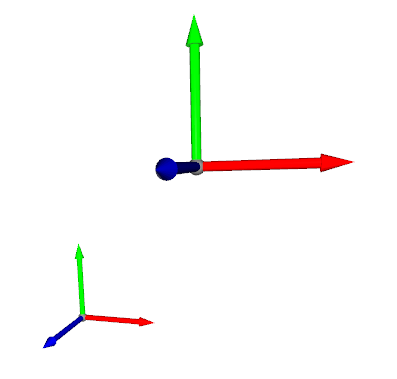

## 旋转

open3d提供了rotate()函数进行旋转，这需要一个旋转矩阵R作为参数。  
open3d提供了3种方式将不同的参数转换为旋转矩阵

### 使用欧拉角生成旋转矩阵

In [5]:
mesh = o3d.geometry.TriangleMesh.create_coordinate_frame()

# 先将mesh进行平移
mesh_r = copy.deepcopy(mesh).translate((2, 2, 2), relative=False)

# 根据欧拉角转换旋转矩阵
R = mesh_r.get_rotation_matrix_from_xyz((np.pi / 2, 0, np.pi / 4))

# 进行旋转
mesh_r.rotate(R, center=(2, 2, 2))

o3d.visualization.draw_geometries([mesh, mesh_r])

可视化结果  
  
  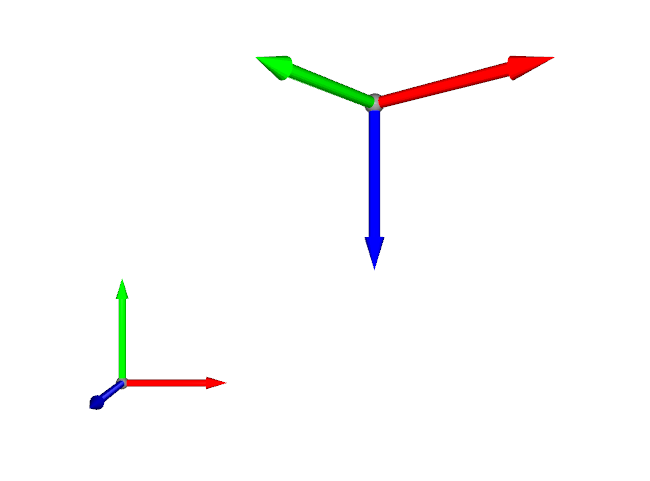

函数Rotate()有第二个参数center，默认设置为True。这表示对象在应用旋转之前首先居中，然后移动回其先前的中心。如果此参数设置为False，则将直接应用旋转，从而使整个几何围绕坐标中心旋转。这意味着旋转后可以更改网格中心。

## 使用轴-角生成旋转矩阵

In [29]:
mesh = o3d.geometry.TriangleMesh.create_coordinate_frame()

# 先将mesh进行平移
mesh_r = copy.deepcopy(mesh).translate((2, 2, 2), relative=False)

# 获取旋转矩阵
R = mesh_r.get_rotation_matrix_from_axis_angle((np.pi / 2, 0, np.pi / 4))

mesh_r.rotate(R, center=(2, 2, 2))
o3d.visualization.draw_geometries([mesh, mesh_r])

可视化结果如下  
  
  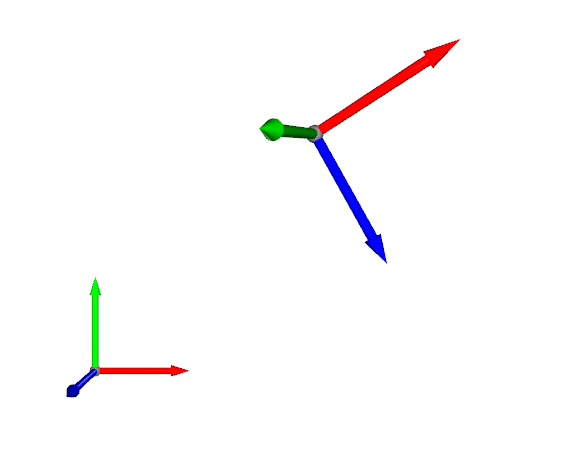

轴角和欧拉角有一定不同，体现在欧拉角在转换过程在旋转轴的方向是变动的，而轴角在转换过程中旋转轴的方向是固定的

还有另外一种方法四元数法 可以参考 https://blog.csdn.net/xiaoma_bk/article/details/79082629  
open3d也提供了open3d.geometry.get_rotation_matrix_from_quaternion方法

## 缩放

open3d提供scale()进行缩放，其中涉及到一个比例因子s作为参数

In [6]:
mesh = o3d.geometry.TriangleMesh.create_coordinate_frame()
mesh_s = copy.deepcopy(mesh).translate((2, 0, 0))

# 缩放至原始的一半
mesh_s.scale(0.5, center=mesh_s.get_center())
o3d.visualization.draw_geometries([mesh, mesh_s])

可视化结果  
  
  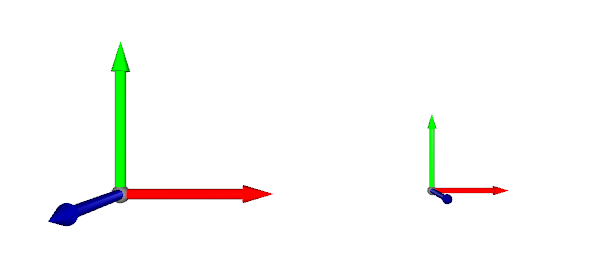

## 常规转换

open3d可以使用4*4的转换矩阵进行转换，需要调用transform()方法  
有关4*4的转换矩阵可以参考 https://zhuanlan.zhihu.com/p/703185920

In [8]:
mesh = o3d.geometry.TriangleMesh.create_coordinate_frame()

# 新建4*4的单位矩阵
T = np.eye(4)

# 设置旋转
T[:3, :3] = mesh.get_rotation_matrix_from_xyz((0, np.pi / 3, np.pi / 2))

# 设置平移
T[0, 3] = 1
T[1, 3] = 1.3

print(T)


mesh_t = copy.deepcopy(mesh).transform(T)
o3d.visualization.draw_geometries([mesh, mesh_t])

[[ 3.06161700e-17 -5.00000000e-01  8.66025404e-01  1.00000000e+00]
 [ 1.00000000e+00  6.12323400e-17  0.00000000e+00  1.30000000e+00]
 [-5.30287619e-17  8.66025404e-01  5.00000000e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


可视化结果如下  
  
  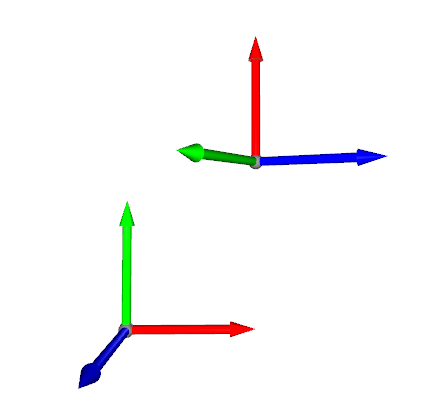

# ISS特征点

ISS的全称为Intrinsic shape signatures，即内在形状特征。在open3d中可以提取ISS特征点  
ISS特征点的相关概念可参考 https://blog.csdn.net/victor_manches/article/details/130417018

In [4]:
# 读取三角网格并计算法向量
pcd = o3d.io.read_point_cloud(r'G:\open3d\data\ArmadilloMesh.ply')

# 调用 o3d.geometry.keypoint中的compute_iss_keypoints计算iss特征点
keypoints = o3d.geometry.keypoint.compute_iss_keypoints(pcd)

# 点云涂成灰色，iss点涂成红色
pcd.paint_uniform_color([0.5, 0.5, 0.5])
keypoints.paint_uniform_color([1.0, 0, 0.0])

o3d.visualization.draw_geometries([keypoints, pcd])

可视化结果如下  
  
  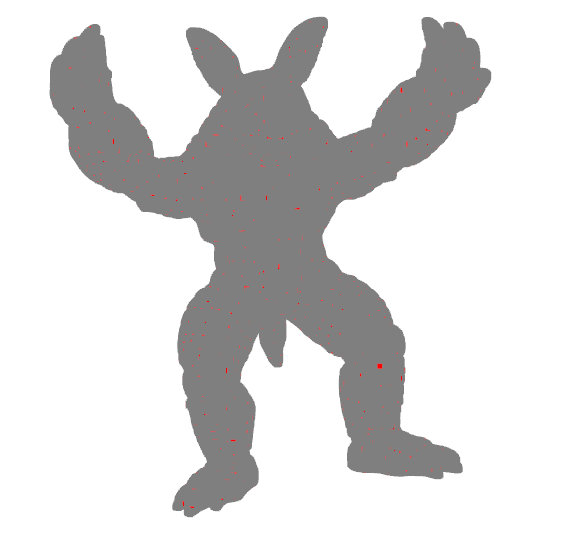

In [5]:
pcd = o3d.io.read_point_cloud(r'G:\open3d\data\BunnyMesh.ply')

keypoints = o3d.geometry.keypoint.compute_iss_keypoints(pcd,
                                                        salient_radius=0.005, # 定义了一个球形邻域，用于计算每个点的显著性。
                                                        non_max_radius=0.005, # 定义了一个球形邻域，用于进行非最大值抑制，避免选择局部最大值。
                                                        gamma_21=0.5, # 用于控制显著性半径内的权重分配。
                                                        gamma_32=0.5) # 用于控制非最大值抑制时的权重分配。


pcd.paint_uniform_color([0.5, 0.5, 0.5])
keypoints.paint_uniform_color([1.0, 0, 0.0])
o3d.visualization.draw_geometries([keypoints, pcd])

可视化结果如下  
  
  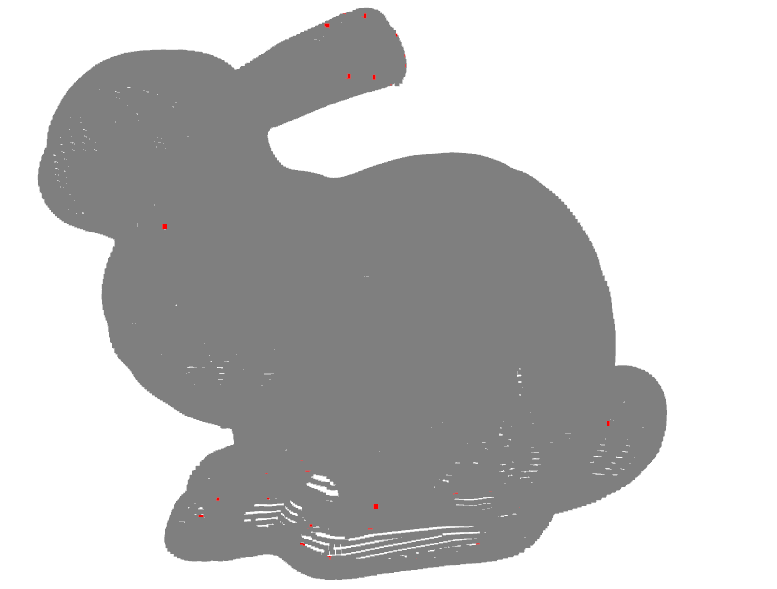